# Trabajo Final Inteligencia Artificial I - año 2018: Visión Artificial
---

# Dependencias
---

In [91]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

from skimage import io, color, img_as_float, img_as_ubyte, filters
from skimage.feature import hog

import cv2
import mahotas

## Funciones definidas

* Representación:

In [92]:
def img2grey(image, mode='sk'):
    if (mode=='sk'):
        gray = color.rgb2gray(image)
    elif (mode=='cv'):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def normSize(image, size=(tuple((100, 100)))):
    image = cv2.resize(image, size)
    return image

* Filtración:

In [93]:
def imgClean(image, sigma=1, mode='sk'):
    if (mode == 'sk'):
        clean = filters.gaussian(image, sigma)
    elif (mode == 'cv'):
        clean = cv2.GaussianBlur(image, (3, 3), 0)
    return clean

def imgEdge(image, mode='sk'):
    if (mode == 'sk'):
        edge = filters.sobel(image)
    elif (mode == 'cv'):
        edge = cv2.Laplacian(image, cv2.CV_64F)
    return edge

- Segmentación:

In [9]:
def threshold(image, mode='sk'):
    if (mode == 'sk'):
        th = filters.threshold_isodata(image)
    elif (mode == 'cv'):
        ret, th = cv2.threshold(image, 0, 255,
                                cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return (image < th)

* Extracción de características:

In [10]:
def m_hog(image):
    feature = hog(image, block_norm='L2-Hys').ravel()
    return feature

def hu_moments(image):
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def haralick(image):
    feature= mahotas.features.haralick(image).mean(axis=0)
    return feature

def color_histogram(image, mask=None, bins=8):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins],
                        [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    feature = hist.flatten()
    return feature

In [11]:
def stats(arr):
    
    sum = 0
    for value in arr:
        sum += value
    med = sum / len(arr)
    sum = 0
    for value in arr:
        sum += np.power((value - med), 2)
    dstd = np.sqrt(sum / (len(arr) - 1))
    
    return med, dstd

# Importar base de datos
---

## Labels

Se obtiene el label de cada categoría. Los labels están dado por la estructura de carpetas: las imágenes de naranjas están en la carpeta "[orange](./data/orange)", las de bananas en la carpeta "[banana](./data/banana)" y las de limones en la carpeta "[lemon](./data/lemon)", todo esto dentro de la carpeta "[data](./data)".

In [57]:
banana = io.ImageCollection('./data/banana/*.png:./data/banana/*.jpg')
orange = io.ImageCollection('./data/orange/*.png:./data/orange/*.jpg')
lemon = io.ImageCollection('./data/lemon/*.png:./data/lemon/*.jpg')

# Extracción de características de toda la base de datos
---

Se crea una clase donde cada instancia de ésta contendrá toda la información necesaria de cada elemento de la base de datos.

In [58]:
class Elemento:
    def __init__(self):
        self.label = None
        self.image = None
        self.feature = []
        self.distance = 0

Se define una función adicional para ver una **barra de progreso** durante el cómputo (las ejecuciones que prosiguen duran segundos si no es que minutos dependiendo el tamaño de la base de datos).
Fuente: [link StackOverflow](https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console)

In [59]:
def printProgressBar(iteration, total, prefix='', suffix='',
                     decimals=1, length=100, fill='█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of
    decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = (
        "{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end='\r')
    # Print New Line on Complete
    if iteration == total:
        print()

La extracción de características queda definida por la siguiente función:

In [89]:
def ft_extract(image):
    image = normSize(image)
    aux = img2grey(image, mode='cv')
    aux = imgClean(aux, mode='cv')
    aux = imgEdge(aux)
    # aux = threshold(aux, mode='cv')
    
    # image_fht = haralick(aux)
    image_fhm = hu_moments(aux)
    # image_fch = color_histogram(image)
    # image_fhog = m_hog(aux)

    # feature = np.hstack([image_fht, image_fhm, image_fhog])
    med, dstd = stats(image_fhm)
    # feature = feature.reshape(1, -1)

    return aux, [med, dstd]

## Análisis de la base de datos

Para cada miembro de la base de datos se instancia un objeto Elemento y se lo llena con toda la información necesaria. Esta información es: el vector de características, la imagen procesada y la etiqueta de clase o _label_.

Loading banana data: |██████████████████████████████████████████████████| 100.0% Complete
Banana data is ready
Loading orange data: |██████████████████████████████████████████████████| 100.0% Complete
Orange data is ready
Loading lemon data: |██████████████████████████████████████████████████| 100.0% Complete
Lemon data is ready
Data analysis completed


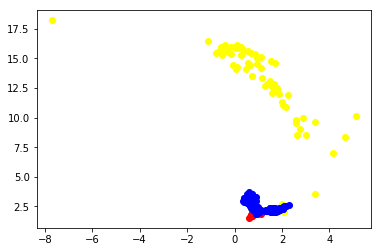

In [94]:
fig_data, ax = plt.subplots()

data = []
i = 0

# Análisis de bananas en base de datos
iter = 0
printProgressBar(iter, len(banana), prefix='Loading banana data:',
                 suffix='Complete', length=50)
for fruit in banana:
    data.append(Elemento())
    data[i].label = 'banana'
    data[i].image, data[i].feature = ft_extract(fruit)
    # print(data[i].feature.shape)
    ax.plot(data[i].feature[0], data[i].feature[1], 'o', color='yellow')
    i += 1
    iter += 1
    printProgressBar(iter, len(banana), prefix='Loading banana data:',
                     suffix='Complete', length=50)
print("Banana data is ready")

# Análisis de naranjas en base de datos
iter = 0
printProgressBar(iter, len(orange), prefix='Loading orange data:',
                 suffix='Complete', length=50)
for fruit in orange:
    data.append(Elemento())
    data[i].label = 'orange'
    data[i].image, data[i].feature = ft_extract(fruit)
    ax.plot(data[i].feature[0], data[i].feature[1], 'o', color='red')
    i += 1
    iter += 1
    printProgressBar(iter, len(orange), prefix='Loading orange data:',
                     suffix='Complete', length=50)
print("Orange data is ready")

# Análisis de limones en la base de datos
iter = 0
printProgressBar(iter, len(lemon), prefix='Loading lemon data:',
                 suffix='Complete', length=50)
for fruit in lemon:
    data.append(Elemento())
    data[i].label = 'lemon'
    data[i].image, data[i].feature = ft_extract(fruit)
    ax.plot(data[i].feature[0], data[i].feature[1], 'o', color='blue')
    i += 1
    iter += 1
    printProgressBar(iter, len(lemon), prefix='Loading lemon data:',
                     suffix='Complete', length=50)
print("Lemon data is ready")

print("Data analysis completed")

In [66]:
print(len(data))
print(data[0].feature)
print(data[0].feature[0])

589
[0.051881905411490695, 0.09571442293121007]
0.051881905411490695


## Test

Se crea un objeto Elemento con la información de la imagen a testear y se la realiza el mismo proceso de extracción de características que para las imágenes de la base de datos:

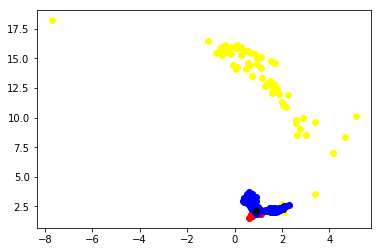

In [95]:
test = Elemento()
image = io.imread('./test/test5.jpg')

test.image, test.feature = ft_extract(image)

test.label = 'banana' # label inicial

ax.plot(test.feature[0], test.feature[1], 'o', color='black')
fig_data

# Algoritmo K-nn (K-nearest neighbors)
---

A continuación se implementa el algoritmo _K-nn_ propiamente dicho, calculando las distancias desde el vector de características de la imagen a testear con toda la base de datos.

También se da un primer resultado que es para el caso especial $K=1$, es decir, el vecino más cercano:

In [96]:
i = 0
sum = 0
for ft in data[0].feature:
        sum = sum + np.power(np.abs(test.feature[i] - ft), 2)
        i += 1
d = np.sqrt(sum)

for element in data:
    sum = 0
    i = 0
    for ft in (element.feature):
        sum = sum + np.power(np.abs((test.feature[i]) - ft), 2)
        i += 1
    
    element.distance = np.sqrt(sum)
    
    if (sum < d):
        d = sum
        test.label = element.label

    
print(test.label)

orange


Se ordena la información según la distancia al elemento a analizar:

In [97]:
 #Bubblesort
swap = True
while (swap):
    swap = False
    for i in range(1, len(data)-1) :
        if (data[i-1].distance > data[i].distance):
            aux = data[i]
            data[i] = data[i-1]
            data[i-1] = aux
            swap = True

Se presentan los resultados obtenidos para $K=10$:

In [98]:
k = 10
for i in range(k):
    print(data[i].label)

orange
lemon
orange
orange
orange
orange
lemon
orange
orange
lemon


# K-means
---

A continuación se realiza el algoritmo K-means, con una breve descripción en cada una de sus etapas para un entendimiento más claro. 

Su objetivo, a diferencia del algoritmo K-nn donde se compara el vector de características de la imagen a clasificar con cada uno de los vectores de la base de datos, es poder identificar un vector principal en cada clase, denominado **mean**, y luego clasificar de forma similar pero solo comparando distancias con estos vectores. De esta forma el algoritmo se puede separar en dos etapas fundamentales: **entrenamiento** de la base de datos, y **clasificación** de la imagen analizada.

## Entrenamiento de la base de datos

El primer paso es asignar $K means$ para las $K$ clases (en este caso de aplicación tres: banana, naranja y limón) de forma aleatoria. En este caso se elige al azar tres miembros de la base de datos:

In [99]:
import random

b_mean = list(random.choice(data).feature)
o_mean = list(random.choice(data).feature)
l_mean = list(random.choice(data).feature)

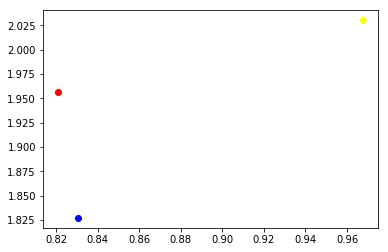

In [100]:
fig, ax = plt.subplots()
ax.plot(b_mean[0], b_mean[1], 'o', color='yellow')
ax.plot(o_mean[0], o_mean[1], 'o', color='red')
ax.plot(l_mean[0], l_mean[1], 'o', color='blue')

Luego el proceso de entrenamiento se divide en tres etapas:
- **Asignación:** Se le da un label a cada elemento de la base de datos según que mean se encuentra a menor distancia.
- **Acualización:** En base a los $K$ grupos formados, se saca el centroide de cada grupo, y dicho centroide pasa a ser el mean de la clase. 

Estos dos pasos se repiten, los mean van modificando su posición hasta que el algoritmo converge y su posición queda fijada.

- **Condición de salida:** En esta implementación se utiliza como condición de salida que la longitud de los tres grupos se mantenga constante. Esto indirectamente quiere decir que la posición de los tres mean será constante. Otra condición diferente podría ser el corte de la ejecución por cantidad de iteraciones.

In [101]:
b_flag = True
o_flag = True
l_flag = True

b_len = 0
o_len = 0
l_len = 0

while (b_flag or o_flag or l_flag):

    banana_data = []
    orange_data = []
    lemon_data = []

    # ASIGNACION

    for element in data:
        sum_b = 0
        sum_o = 0
        sum_l = 0

        i = 0
        for feature in (element.feature):
            sum_b += np.power(np.abs(b_mean[i] - feature), 2)
            sum_o += np.power(np.abs(o_mean[i] - feature), 2)
            sum_l += np.power(np.abs(l_mean[i] - feature), 2)
            i += 1

        dist_b = np.sqrt(sum_b)
        dist_o = np.sqrt(sum_o)
        dist_l = np.sqrt(sum_l)

        if ((dist_b <= dist_o) and (dist_b <= dist_l)):
            element.label = 'banana'
            banana_data.append(element.feature)
        elif ((dist_o <= dist_b) and (dist_o <= dist_l)):
            element.label = 'orange'
            orange_data.append(element.feature)
        elif ((dist_l <= dist_b) and (dist_l <= dist_o)):
            element.label = 'lemon'
            lemon_data.append(element.feature)

    # ACTUALIZACION
    i = 0
    for i in range(0, len(data[0].feature)-1):
        sum_b = 0
        for b in banana_data:
            sum_b += b[i]
        sum_o = 0
        for o in orange_data:
            sum_o += o[i]
        sum_l = 0
        for l in lemon_data:
            sum_l += l[i]

        b_mean[i] = sum_b / len(banana_data)
        o_mean[i] = sum_o / len(orange_data)
        l_mean[i] = sum_l / len(lemon_data)
    
    # CONVERGENCIA Y CONDICIÓN DE SALIDA
    #print(len(banana_data), len(orange_data), len(lemon_data))
    
    if (len(banana_data) == b_len):
        b_flag = False
    else:
        b_len = len(banana_data)
        
    if (len(orange_data) == o_len):
        o_flag = False
    else:
        o_len = len(orange_data)

    if (len(lemon_data) == l_len):
        l_flag = False
    else:
        l_len = len(lemon_data)

### Ubicación de los means finales

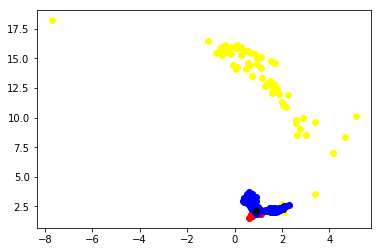

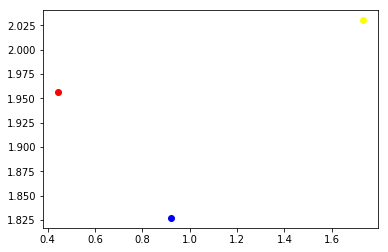

In [104]:
fig_means, ax = plt.subplots()
ax.plot(b_mean[0], b_mean[1], 'o', color='yellow')
ax.plot(o_mean[0], o_mean[1], 'o', color='red')
ax.plot(l_mean[0], l_mean[1], 'o', color='blue')

fig_data

## Resultado final

Se comparan las distancias del vector de características de la imagen a testear con los means finales obtenidos. La clase de la imagen será la del mean más cercano.

In [103]:
sum_b = 0
sum_o = 0
sum_l = 0

for i in range(0, len(test.feature)-1):
    sum_b += np.power(np.abs(test.feature[i] - b_mean[i]), 2)
    sum_o += np.power(np.abs(test.feature[i] - o_mean[i]), 2)
    sum_l += np.power(np.abs(test.feature[i] - l_mean[i]), 2)

dist_b = np.sqrt(sum_b)
dist_o = np.sqrt(sum_o)
dist_l = np.sqrt(sum_l)
print(dist_b, dist_o, dist_l)

if ((dist_b <= dist_o) and (dist_b <= dist_l)):
    test.label = 'banana'
if ((dist_o <= dist_b) and (dist_o <= dist_l)):
    test_label = 'orange'
if ((dist_l <= dist_b) and (dist_l <= dist_o)):
    test.label = 'lemon'

print(test.label)

0.8325036186270265 0.45302219179023717 0.022221565878736693
lemon
